# Udacity Self-Driving Car Engineer Nanodegree Program
## Project 5: Vehicle Detection and Tracking

### Import Packages

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import pickle
import time
from sklearn.svm import LinearSVC
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

### Data Exploration
In this section, I explored the dataset to see what I'm working with. The datasets used (recommanded in Udacity course contents) are comprised of images taken from the GTI vehicle image database, the KITTI vision benchmark suite, and examples extracted from the project video itself.

The datasets consists a count of 8792  cars and 8968  non-cars
of size:  (64, 64, 3)  and data type: float32


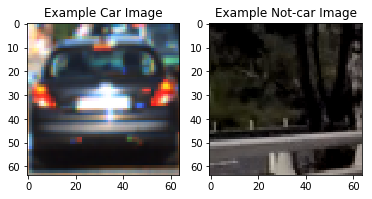

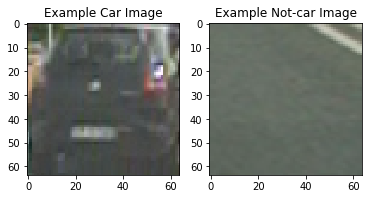

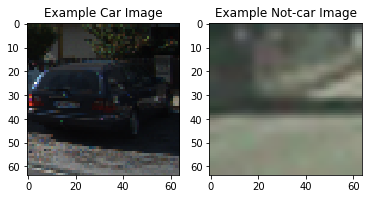

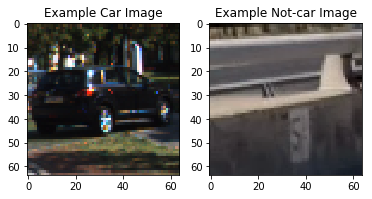

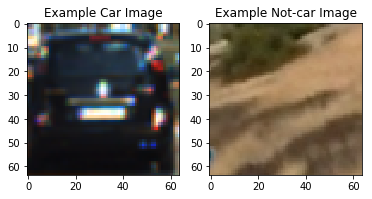

In [20]:
car_images = glob.glob('./training_data/vehicles/vehicles/*/*.png')
notcar_images = glob.glob('./training_data/non-vehicles/non-vehicles/*/*.png')

data_dict = {}
# Define a key in data_dict "n_cars" and store the number of car images
data_dict["n_cars"] = len(car_images)
# Define a key "n_notcars" and store the number of notcar images
data_dict["n_notcars"] = len(notcar_images)
# Read in a test image, either car or notcar
img = mpimg.imread(car_images[0])
# Define a key "image_shape" and store the test image shape 3-tuple
data_dict["image_shape"] = img.shape
# Define a key "data_type" and store the data type of the test image.
data_dict["data_type"] = img.dtype

print('The datasets consists a count of', 
      data_dict["n_cars"], ' cars and', 
      data_dict["n_notcars"], ' non-cars')
print('of size: ',data_dict["image_shape"], ' and data type:', 
      data_dict["data_type"])

# Just for fun choose random car / not-car indices and plot example images
for i in range(5):
    car_ind = np.random.randint(0, len(car_images))
    notcar_ind = np.random.randint(0, len(notcar_images))
    
    # Read in car / not-car images
    car_image = mpimg.imread(car_images[car_ind])
    notcar_image = mpimg.imread(notcar_images[notcar_ind])

    # Plot the examples
    fig = plt.figure()
    plt.subplot(121)
    plt.imshow(car_image)
    plt.title('Example Car Image')
    plt.subplot(122)
    plt.imshow(notcar_image)
    plt.title('Example Not-car Image')

### Color Feature
Train a classifier using color features. After read in car and non-car images, extract the color features for each, and scale the feature vectors to zero mean and unit variance. bin_spatial(), color_hist(), and extract_features() defined are adapted from course material

In [21]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features_color(imgs, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256)):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        else: feature_image = np.copy(image)      
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_features, hist_features)))
    # Return list of feature vectors
    return features

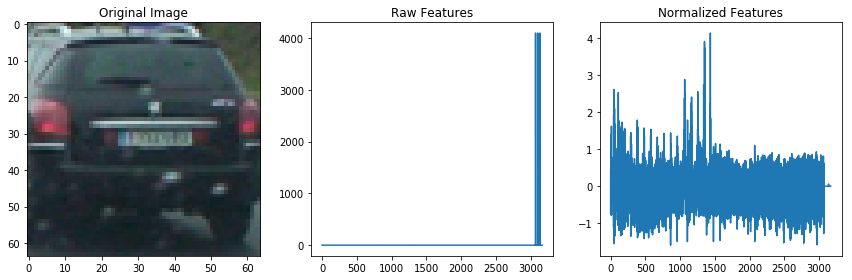

In [22]:
car_features = extract_features_color(car_images, cspace='YUV', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256))
notcar_features = extract_features_color(notcar_images, cspace='YUV', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256))

if len(car_features) > 0:
    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    car_ind = np.random.randint(0, len(car_images))
    # Plot an example of raw and scaled features
    fig = plt.figure(figsize=(12,4))
    plt.subplot(131)
    plt.imshow(mpimg.imread(car_images[car_ind]))
    plt.title('Original Image')
    plt.subplot(132)
    plt.plot(X[car_ind])
    plt.title('Raw Features')
    plt.subplot(133)
    plt.plot(scaled_X[car_ind])
    plt.title('Normalized Features')
    fig.tight_layout()
else: 
    print('Your function only returns empty feature vectors...')

### HOG Feature
#### Get HOG Features Using scikit-image HOG
Define functions to get HOG. This function is duplicated from class materials 

In [23]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        # Get both features and visualization
        features, hog_image = hog(img, orientations=orient,
                          pixels_per_cell=(pix_per_cell, pix_per_cell), 
                          cells_per_block=(cell_per_block, cell_per_block), 
                          visualise=True, feature_vector=False,
                          block_norm="L2-Hys")
        return features, hog_image
    else:      
        # Use skimage.hog() to get features only
        features = hog(img, orientations=orient,
                          pixels_per_cell=(pix_per_cell, pix_per_cell), 
                          cells_per_block=(cell_per_block, cell_per_block), 
                          visualise=False, feature_vector=feature_vec,
                          block_norm="L2-Hys")
        return features

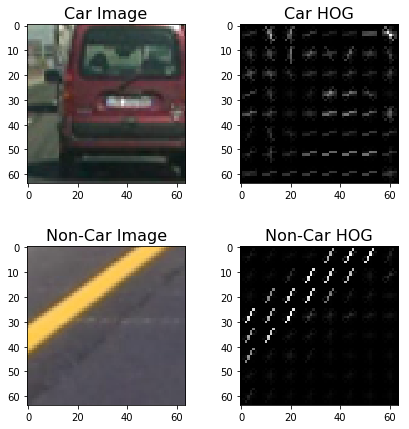

In [24]:
# Generate a random index to look at a car/not-car image
car_ind = np.random.randint(0, len(car_images))
notcar_ind = np.random.randint(0, len(notcar_images))
# Read in the image
car_image = mpimg.imread(car_images[car_ind])
car_gray = cv2.cvtColor(car_image, cv2.COLOR_RGB2GRAY)
notcar_image = mpimg.imread(notcar_images[notcar_ind])
notcar_gray = cv2.cvtColor(notcar_image, cv2.COLOR_RGB2GRAY)
# Define HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2
# Call our function with vis=True to see an image output
car_features, car_hog_image = get_hog_features(car_gray, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)
notcar_features, notcar_hog_image = get_hog_features(notcar_gray, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)


# Visualize 
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(7,7))
f.subplots_adjust(hspace = .4, wspace=.2)
ax1.imshow(car_image)
ax1.set_title('Car Image', fontsize=16)
ax2.imshow(car_hog_image, cmap='gray')
ax2.set_title('Car HOG', fontsize=16)
ax3.imshow(notcar_image)
ax3.set_title('Non-Car Image', fontsize=16)
ax4.imshow(notcar_hog_image, cmap='gray')
ax4.set_title('Non-Car HOG', fontsize=16)

### Combine Color and HOG Features

In [25]:
# Define a function to extract features from a list of images using both color and hog features
def img_features(feature_image, cspace='RGB', spatial_size=(32,32), hist_bins=32, hist_range=(0, 256), 
                        orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feature=True, hist_feature=True, hog_feature=True):
    # Create a list to append feature vectors from single image
    file_features = []
        
    if spatial_feature == True:
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        file_features.append(spatial_features)
        
    if hist_feature == True:
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        file_features.append(hist_features)
        
    if hog_feature == True:
        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                orient, pix_per_cell, cell_per_block, 
                                vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        file_features.append(hog_features)
        
    return file_features

def extract_features(imgs, cspace='RGB', spatial_size=(32,32), hist_bins=32, hist_range=(0, 256), 
                        orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feature=True, hist_feature=True, hog_feature=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)    
        
        file_features = img_features(feature_image, cspace, spatial_size, hist_bins, hist_range, 
                        orient, pix_per_cell, cell_per_block, hog_channel,
                        spatial_feature, hist_feature, hog_feature)
           
        features.append(np.concatenate(file_features))
        
        # Augment the dataset with flipped images
        #feature_image_flip=cv2.flip(feature_image,1) 
        #file_features = img_features(feature_image_flip, cspace, spatial_size, hist_bins, hist_range, 
                        #orient, pix_per_cell, cell_per_block, hog_channel,
                        #spatial_feature, hist_feature, hog_feature)
           
        #features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

### Extracting Features

In [26]:
# Feature extraction parameters 
spatial_size = (32, 32)
hist_bins = 32
cspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 15
pix_per_cell = 8
cell_per_block = 2
hist_range = (0, 256)
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_feature = True # Spatial features on or off
hist_feature = True # Histogram features on or off
hog_feature = True # HOG features on or off

t=time.time()
car_features = extract_features(car_images, cspace=cspace, 
                        spatial_size=spatial_size, hist_bins=hist_bins, hist_range=hist_range,
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feature=spatial_feature, 
                        hist_feature=hist_feature, hog_feature=hog_feature)
print('Car samples: ', len(car_features))
notcar_features = extract_features(notcar_images, cspace=cspace, 
                        spatial_size=spatial_size, hist_bins=hist_bins, hist_range=hist_range,
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feature=spatial_feature, 
                        hist_feature=hist_feature, hog_feature=hog_feature)
print('Notcar samples: ', len(notcar_features))

t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract figure features...')
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('For HOG feature, using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')


# Save the parameters for later use if needed
dist_pickle = {}
dist_pickle["spatial_size"] = spatial_size
dist_pickle["hist_bins"] = hist_bins
dist_pickle["cspace"] = cspace
dist_pickle["orient"] = orient
dist_pickle["pix_per_cell"] = pix_per_cell
dist_pickle["cell_per_block"] = cell_per_block
dist_pickle["hist_range"] = hist_range
dist_pickle["hog_channel"] = hog_channel
dist_pickle["svc"] = svc
dist_pickle["scaler"] = X_scaler
dist_pickle["spatial_feature"] = spatial_feature
dist_pickle["hog_feature"] = hog_feature
dist_pickle["hist_feature"] = hist_feature
pickle.dump( dist_pickle, open( "svc_pickle.p", "wb" ) )

Car samples:  8792
Notcar samples:  8968
110.71 Seconds to extract figure features...
For HOG feature, using: 15 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 11988
42.07 Seconds to train SVC...
Test Accuracy of SVC =  0.9811
My SVC predicts:  [ 1.  0.  1.  1.  1.  1.  0.  0.  0.  0.]
For these 10 labels:  [ 1.  0.  1.  1.  1.  1.  0.  0.  0.  0.]
0.00902 Seconds to predict 10 labels with SVC


### Hog Sub-sampling Window Search

Uses Hog Sub-sampling Window Search. The code below is adapted from course material and defines a single function find_cars that's able to both extract features and make predictions.

In [30]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, cspace, hog_channel, svc, X_scaler, orient, 
              pix_per_cell, cell_per_block, spatial_size, hist_bins, hist_range,
              show_all_rec = False):
      
    # array of rectangles where cars were detected
    rectangles = []
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    img_tosearch = img[ystart:ystop,:,:]
    
    # Apply color conversion if other than 'RGB'
    if cspace != 'RGB':
        if cspace == 'HSV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    else: ctrans_tosearch = np.copy(image)
        
    # Rescale image if other than 1.0 scale
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    # Select colorspace channel for HOG 
    if hog_channel == 'ALL':
        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]
    else: 
        ch1 = ctrans_tosearch[:,:,hog_channel]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    #nxblocks = (ch1.shape[1] // pix_per_cell) +1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1
    #nyblocks = (ch1.shape[0] // pix_per_cell) +1
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    #nblocks_per_window = (window // pix_per_cell)-1
    
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=False)
    if hog_channel == 'ALL':
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            if hog_channel == 'ALL':
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            else:
                hog_features = hog_feat1

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins, bins_range=hist_range)

            # Scale features and make a prediction
            #test_features = X_scaler.transform(np.hstack((hog_features)).reshape(1, -1))
            #test_features = X_scaler.transform(np.hstack((spatial_features, hog_features)).reshape(1, -1))    
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))     
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1 or show_all_rec == True:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6)
                rectangles.append(((int(xbox_left), int(ytop_draw+ystart)),(int(xbox_left+win_draw),int(ytop_draw+win_draw+ystart)))) 
                
    return draw_img, rectangles

#### Draw Detected Rectangles onto Image

In [31]:
# Here is your draw_boxes function from the previous exercise
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    random_color = False
    # Iterate through the bounding boxes
    for bbox in bboxes:
        if color == 'random' or random_color:
            color = (np.random.randint(0,255), np.random.randint(0,255), np.random.randint(0,255))
            random_color = True
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

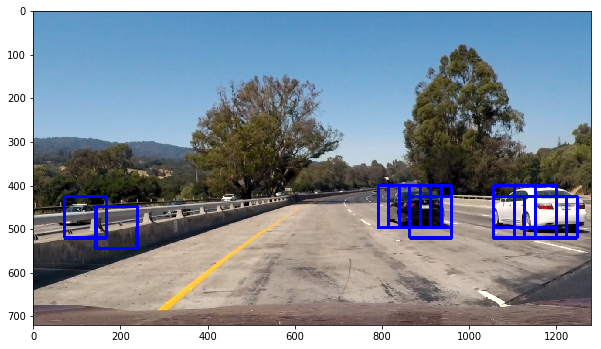

In [32]:
test_image = glob.glob('./test_images/test1.jpg')

ystart = 400
ystop = 656
scale = 1.5

for img in test_image:
    image = mpimg.imread(img)

    result, rectangles = find_cars(image, ystart, ystop, scale, cspace, hog_channel, svc, X_scaler, orient, 
              pix_per_cell, cell_per_block, spatial_size, hist_bins, hist_range,show_all_rec = False)
    plt.figure(figsize=(10,10))
    plt.imshow(result)

As we can see on test images above, the classifier successfully finds cars on the test images. However, the classifier failed to find some cars that are very small. Therefore, we will need to use multi scale windows. Also to reduce false postive identifications, we need to apply some filter.

### Multiscale Search
#### Show All Potential Search Areas
The size and position of cars in the image will be different depending on their distance from the camera. So we can call `find_cars` a few times with different ystart, ystop, and scale values. These next few blocks of code are for determining the values for these parameters that work best.

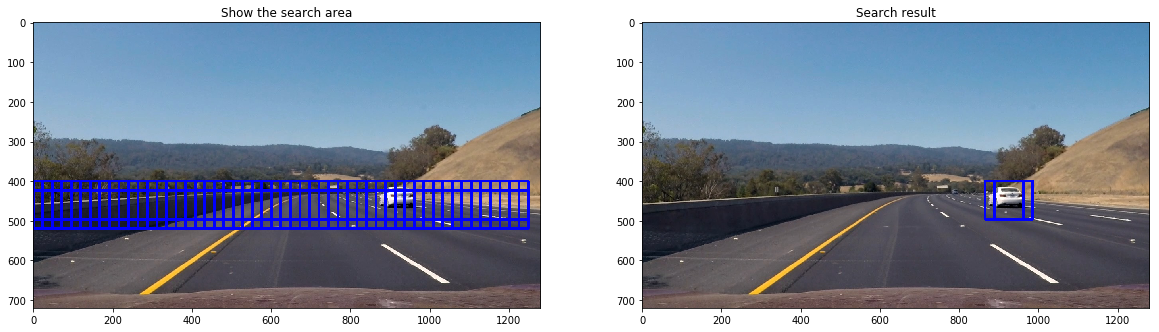

In [33]:
image = mpimg.imread('./test_images/test3.jpg')

ystart =400
ystop = 560
scale = 1.5

result, rects = find_cars(image, ystart, ystop, scale, cspace, hog_channel, svc, X_scaler, orient, 
              pix_per_cell, cell_per_block, spatial_size, hist_bins, hist_range, show_all_rec = True)

fig = plt.figure(figsize=(20,20))
plt.subplot(121)
plt.imshow(result)
plt.title('Show the search area')

result, rects = find_cars(image, ystart, ystop, scale, cspace, hog_channel, svc, X_scaler, orient, 
              pix_per_cell, cell_per_block, spatial_size, hist_bins, hist_range, show_all_rec = False)

plt.subplot(122)
plt.imshow(result)
plt.title('Search result')

#### Test Multi-Scale Window Search

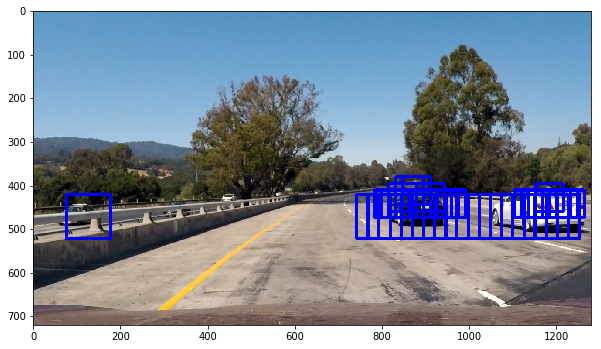

In [43]:
image = mpimg.imread('./test_images/test1.jpg')

#ystart_list = [400, 400, 410, 420, 430, 430, 430, 400, 500]
#ystop_list = [500, 500, 500, 556, 556, 556, 556, 556, 656]
#scale_list = [1.0, 1.3, 1.4, 1.6, 1.8, 1.9, 2.0, 2.2, 3.0]


ystart_list = [380, 410, 420, 430, 400, 500]
ystop_list = [490, 490, 556, 556, 556, 656]
scale_list = [1.0, 1.0, 1.6, 2.0, 2.2, 3.0]

rects = []
    
for i in range(len(ystart_list)):
    ystart = ystart_list[i] # smaller y smaller car- smaller window
    ystop = ystop_list[i]
    scale = scale_list[i]
    
    if i == 0:
        out_img, rectangles = find_cars(image, ystart, ystop, scale, cspace, hog_channel, svc, X_scaler, orient, 
              pix_per_cell, cell_per_block, spatial_size, hist_bins, hist_range, show_all_rec = False)
        rects.extend(rectangles)
    else:
        out_img, rectangles = find_cars(out_img, ystart, ystop, scale, cspace, hog_channel, svc, X_scaler, orient, 
              pix_per_cell, cell_per_block, spatial_size, hist_bins, hist_range, show_all_rec = False)
        rects.extend(rectangles)
        
plt.figure(figsize=(10,10))
plt.imshow(out_img)

**Note:** From teh results, we can see that all cars are succefully classified, even cars on the other side of the road are classified. However, there are multiple detection on same vehicle. Next step would be reduce false positive and merge repetitive detection using heatmap.

### Multiple Detections & False Positives
This method (duplicated from lesson material) produces a heat map based on rectangle locations (additive with overlap).

In [35]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

2 cars found


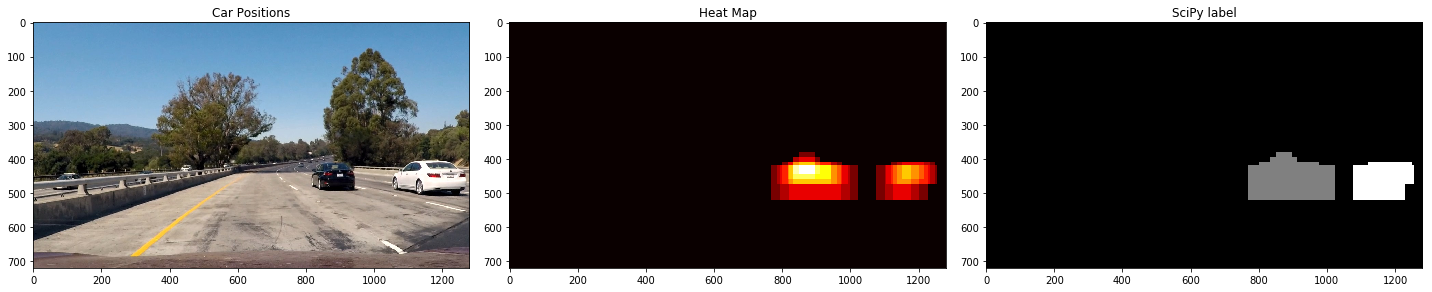

In [45]:
# Test out the heatmap
image = mpimg.imread('./test_images/test1.jpg')

heat = np.zeros_like(image[:,:,0]).astype(np.float)
    
# Add heat to each box in box list
heat_map = add_heat(heat, rects)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat_map,1)
    
# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)
    
# Find final boxes from heatmap using label function
labels = label(heatmap)
    
print(labels[1], 'cars found')
fig = plt.figure(figsize=(20,20))
plt.subplot(131)
plt.imshow(image)
plt.title('Car Positions')
plt.subplot(132)
plt.imshow(heat_map, cmap='hot')
plt.title('Heat Map')
plt.subplot(133)
plt.imshow(labels[0], cmap='gray')
plt.title('SciPy label')
fig.tight_layout()

#### Draw Bounding Boxes for Labels

In [46]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])|
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

SyntaxError: invalid syntax (<ipython-input-46-2dc5c458c13d>, line 7)

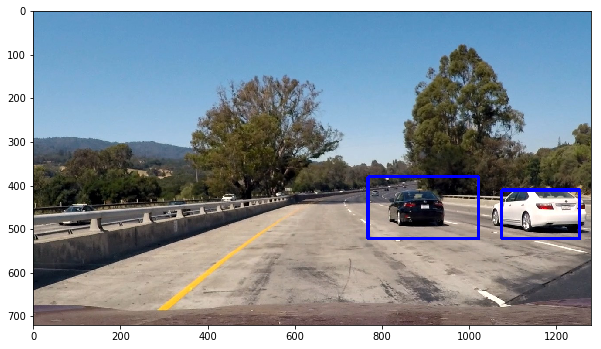

In [47]:
# Draw bounding boxes on a copy of the image

image = mpimg.imread('./test_images/test1.jpg')

draw_img = draw_labeled_bboxes(np.copy(image), labels)
# Display the image
plt.figure(figsize=(10,10))
plt.imshow(draw_img)

### Define Final Process Pipeline

In [39]:
def process_img(img):
    # Read in Parameters
    #ystart_list = [380, 400, 430, 400, 500]
    #ystop_list = [490, 556, 556, 556, 656]
    #scale_list = [1.0, 1.5, 2.0, 2.2, 3.0]

    #dist_pickle = pickle.load( open("svc_pickle.p", "rb" ) )
    #svc = dist_pickle["svc"]
    #X_scaler = dist_pickle["scaler"]
    #orient = dist_pickle["orient"]
    #pix_per_cell = dist_pickle["pix_per_cell"]
    #cell_per_block = dist_pickle["cell_per_block"]
    #spatial_size = dist_pickle["spatial_size"]
    #hist_bins = dist_pickle["hist_bins"]
    #cspace = dist_pickle["cspace"]
    #hist_range = dist_pickle["hist_range"]
    #hog_channel = dist_pickle["hog_channel"]
    
    rects = []
    
    for i in range(len(ystart_list)):
        ystart = ystart_list[i] # smaller y smaller car- smaller window
        ystop = ystop_list[i]
        scale = scale_list[i]
    
        out_img, rectangles = find_cars(image, ystart, ystop, scale, cspace, hog_channel, svc, X_scaler, orient, 
                  pix_per_cell, cell_per_block, spatial_size, hist_bins, hist_range, show_all_rec = False)
        rects.extend(rectangles)
    
    heat= np.zeros_like(img[:,:,0])
    
    # Add heat to each box in box list
    heat = add_heat(heat, rects)
    
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,1)
    
    # Find final boxes from heatmap using label function
    labels = label(heat)
    
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    
    return draw_img

#### Test Pipeline on all image

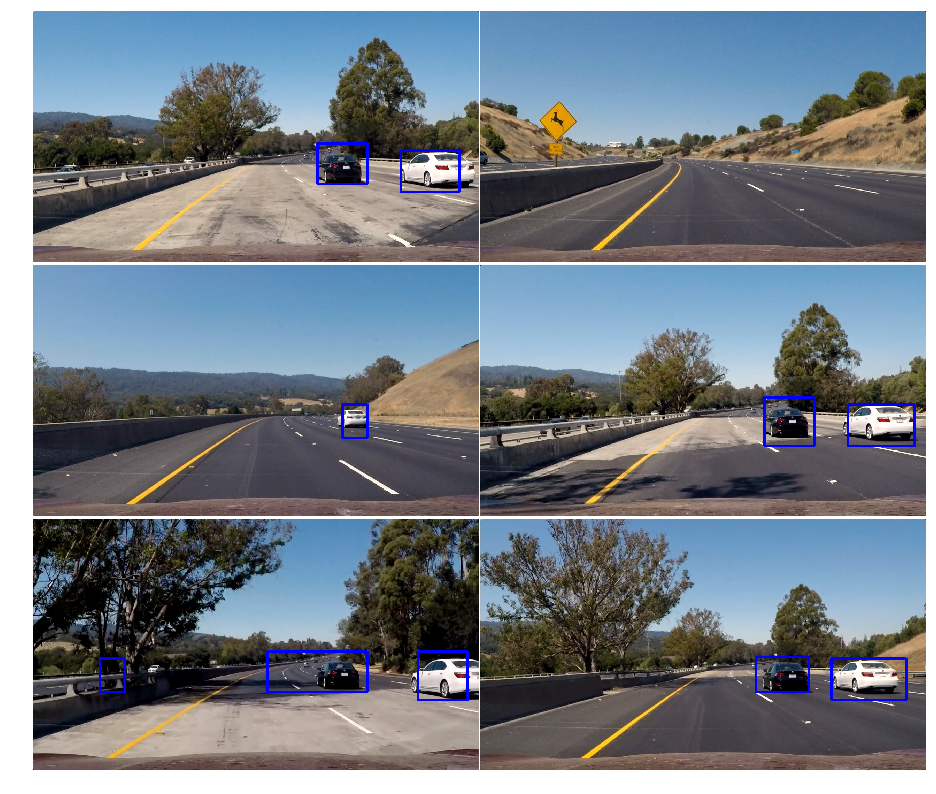

In [40]:
# Read in Parameters
ystart_list = [380, 400, 430, 400, 500]
ystop_list = [490, 556, 556, 556, 656]
scale_list = [1.0, 1.5, 2.0, 2.2, 3.0]

dist_pickle = pickle.load( open("svc_pickle.p", "rb" ) )
svc = dist_pickle["svc"]
X_scaler = dist_pickle["scaler"]
orient = dist_pickle["orient"]
pix_per_cell = dist_pickle["pix_per_cell"]
cell_per_block = dist_pickle["cell_per_block"]
spatial_size = dist_pickle["spatial_size"]
hist_bins = dist_pickle["hist_bins"]
cspace = dist_pickle["cspace"]
hist_range = dist_pickle["hist_range"]
hog_channel = dist_pickle["hog_channel"]

# Read in test images
test_images = glob.glob('./test_images/test*.jpg')

fig, axs = plt.subplots(3, 2, figsize=(16,14))
fig.subplots_adjust(hspace = .004, wspace=.002)
axs = axs.ravel()
    
for i,img in enumerate(test_images):
    image = mpimg.imread(img)
    axs[i].imshow(process_img(image))
    axs[i].axis('off')    

    

**Note:** There is still false positive detection on test5.jpg. However, I tried different paramters. This is still the best result I got so far.

### Run Vedio Through Pipeline

In [41]:
test_out_file = 'test_video_out.mp4'
clip_test = VideoFileClip('test_video.mp4')
clip_test_out = clip_test.fl_image(process_img)
%time clip_test_out.write_videofile(test_out_file, audio=False)

[MoviePy] >>>> Building video test_video_out.mp4
[MoviePy] Writing video test_video_out.mp4


 97%|███████████████████████████████████████████████████████████████████████████████▉  | 38/39 [00:24<00:00,  1.56it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_out.mp4 

Wall time: 25.2 s


In [42]:
proj_out_file = 'project_video_out.mp4'
clip_proj = VideoFileClip('project_video.mp4') 
clip_proj_out = clip_proj.fl_image(process_img)
%time clip_proj_out.write_videofile(proj_out_file, audio=False)

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [14:11<00:00,  1.47it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

Wall time: 14min 11s
